# Day 3.2 Classification

<div class="alert alert-block alert-info">

## Learning Objectives

- Understand the principles of classification and differentiate logistic regression from decision trees.  
- Train and evaluate models using metrics like accuracy, precision, recall, and F1-score.  
- Interpret the coefficients of logistic regression and the structure of decision trees.  
- Identify and mitigate overfitting using regularization (logistic regression) and pruning (decision trees).  
- Compare and select models based on interpretability, complexity, and real-world applications.
</div>

A common task in computational research is to classify an object based on a set of features. In supervised machine learning, we can give an algorithm a dataset of training examples that say "here are specific features, and this is the target class it belongs to". With enough training examples, a model can be built that recognizes important features in determining an object's class. This model can then be used to predict the class of an object given its known features.


First let's import the packages that we need for this notebook.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Heart Data

Let's import the heart failure prediction data set we have created from the previous activity;

In [46]:
X_train = pd.read_csv('../data/heart_X_train.csv')
X_test = pd.read_csv('../data/heart_X_test.csv')
y_train = pd.read_csv('../data/heart_y_train.csv')
y_test = pd.read_csv('../data/heart_y_test.csv')

In [47]:
y_train.head()

,Unnamed: 0,HeartDisease
0,464,1
1,745,1
2,916,1
3,515,0
4,905,1


In [48]:
X_train.head()

,Unnamed: 0,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,FastingBS_1,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.567297,-0.071588,0.000000,-0.315440,1.093068
1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.990034,-1.343739,0.501296,1.260397,0.898379
2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.355928,-0.126899,-0.132316,1.452572,-0.853818
3,3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.990034,-0.126899,0.000000,0.914482,2.066511
4,4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.412771,1.089941,-0.593126,0.530131,-0.075064


## Null Accuracy

Let's say that we wanted to predict if a patient might experience heart failure. One way to do this is to assign all observations to the majority classes. The code below shows the proportion of each condition for heart disease in the training data.

**Question:** If we want to maximize accuracy, which species label would we assign to all observations? 

In [49]:
y_train.value_counts('HeartDisease')/sum(y_train.value_counts('HeartDisease'))

HeartDisease
1    0.553134
0    0.446866
Name: count, dtype: float64

This accuracy is our **baseline model**, and is the number that we will try to improve on with classification.

Let's get to know our dataset by conducting some exploratory data analysis. We'll be using some rudimentary data analysis to see there's a relationship between the independent variables across species.

Let's say that we decide that max HR might be a good way to differentiate between presence and absence of heart disease. We can look at a plot of the histogram to see how the distribution of this variable changes between heart disease conditions.

**Question**: Where would you place a line to minimize the overlap in the distribution? 

<Axes: xlabel='MaxHR', ylabel='Count'>

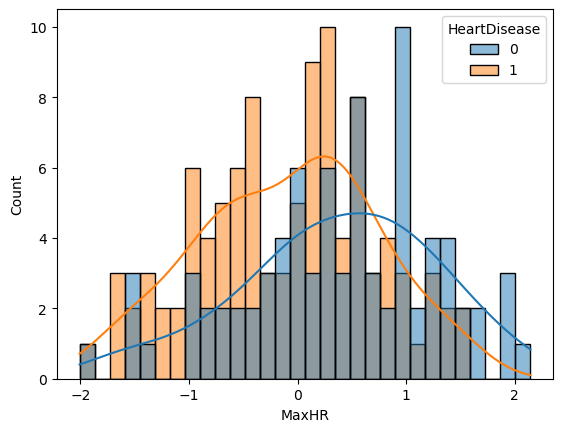

In [50]:
sb.histplot(data=X_test,
                x = 'MaxHR',
                hue = y_test['HeartDisease'],kde=True,bins=30)
#plt.axvline(-0.2,color= 'red')

Now let's apply this same decision boundary to the test data. 

**Question:** Is this still the best boundary?

This is the basic goal of classification. Based on your boundary criteria, you would **classify** all each of the hearts. However there would be some error involved. We can be more confident in our classification at the far ends of the distribution, and less confident where the distributions overlap. 


Now let's figure out how to separate out these groups mathematically. For this, we will start by using an algorithm called Logistic Regression.

## Logistic Regression

Logistic regression is a supervised classification algorithm that is used to predict a binary outcome. Similar to linear regression, this model uses coefficients or betas to make its predictions. However unlike a linear regression, its predictions range from 0 to 1, where 0 and 1 stand for 'confidently class A and B' respectively. Predictions along the middle of the line show less confidence in the prediction.

The function for the logistic regression is:
$$ p(x) = \frac{1}{1 + e^{(-\beta_0+\beta_1x_1...)}}$$

where $\beta$ are the learned parameters and $x$ are the input features.


Let's train a logistic regression model on the variable: `MaxHR`

### Modeling with Logistic Regression


Logistic regression uses the same general steps as many other `sklearn` algorithms:
1. Initialize Model
2. Fit model on training data
3. Evaluate on training and testing datasets

In [51]:
#1) Initialize Model
lr = LogisticRegression(max_iter=170)

#2) Fit model
lr.fit(X_train['MaxHR'].values.reshape(-1, 1), y_train['HeartDisease'])

#3) Evaluate 
train_score = lr.score(X_train['MaxHR'].values.reshape(-1, 1), y_train['HeartDisease'])
test_score = lr.score(X_test['MaxHR'].values.reshape(-1, 1), y_test['HeartDisease'])

print("Training score:", train_score.round(3), "Testing score:", test_score.round(3))

Training score: 0.687 Testing score: 0.598


**Question:** How well did the model do compared to baseline?

## Multivariate Logistic Regression


The logistic regression did a pretty good job at classifying the heart diseases. However, we have more than just Max HR to base our decision of heart disease. For example, let's look at the combination of `Max HR` and `Age` in our data by using a scatterplot.

In the two dimensional space, the intuition is that we want to draw a line that separates the classes. 

**Question:** Is it possible to draw a line that separates the groups? If it is, this is a **linearly seperable** problem

<Axes: xlabel='MaxHR', ylabel='Age'>

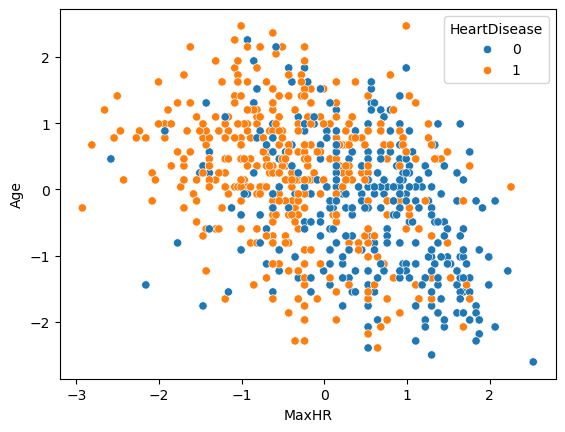

In [52]:
sb.scatterplot(data=X_train,
                x = 'MaxHR',
                y = 'Age',
                hue = y_train['HeartDisease'])

Let's retrain the logistic model with two variables.

In [53]:
lr = LogisticRegression(max_iter=170)
lr.fit(X_train[['MaxHR','Age']], y_train['HeartDisease'])

train_score = lr.score(X_train[['MaxHR','Age']], y_train['HeartDisease'])
test_score = lr.score(X_test[['MaxHR','Age']], y_test['HeartDisease'])

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))


Training score = 0.704, testing score = 0.641


As most things in real life, we got a decent but not a great score.

Now let's take a look at the coefficients of the model. We reference the `lr.coef_` attribute to see the coefficients

In [54]:
coef = pd.Series(index=['MaxHR','Age'], data=lr.coef_[0])

coef.sort_values()

MaxHR   -0.930337
Age      0.294876
dtype: float64

**Question:** What do you think the *magnitude* and *sign* of the coefficients means about how these variables are related to each category?
**Hint:** Refer back to the scatter plot!

## Model evaluation

We've covered accuracy already but there a whole litany of other ways to evaluate the performance of a classification model.

In a binary classification task, there are four major types of predictions:

[Confusion Matrix (Wikipedia)](https://en.wikipedia.org/wiki/Confusion_matrix): 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result which wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result which wrongly indicates that a particular condition or attribute is absent


Accuracy, which is the most common metric used with classification can be characterized as:

$$ Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

We can combine the prediction measures above to create three helpful metrics for evaluating classification: **precision**, **recall**, and **specificity**. 


1. **Precision**: 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$


Let's make a confusion matrix and derive the recall and precision scores.

First, let's go back to the original (not perfect) model so we can see what these rates look like.

First we will retrain the model and make predictions on the test set.

In [55]:
lr.fit(X_train[['MaxHR','Age']], y_train['HeartDisease'])
preds = lr.predict(X_test[['MaxHR','Age']])

In [56]:
# Pass y_test and preds into confusion_matrix
confusion_matrix(y_test['HeartDisease'], preds)

array([[49, 33],
       [33, 69]])

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test['HeartDisease'], preds).ravel()

## 🦾 Challenge: Let's make a more complicated model

In [79]:
# put your code here

## Challenge 1: Model Evaluation

1). What are the TP, FP, TN, FN in these model results?

2). What is the precision and recall for this model?

3). Which is more important, precision or recall?

Depending on your task, other metrics than accuracy might be more beneficial to understanding your model's performance. At the very least, examining the confusion matrix is a great way to get a better sense of how your model is performing across classes.

### Can we add regularization terms and make the model better?

In [77]:
# Apply L1 regularization
lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=170, C=1.0)  # Adjust C for regularization strength
lr.fit(X_train, y_train['HeartDisease'])

# Evaluate the model
train_score = lr.score(X_train, y_train['HeartDisease'])
test_score = lr.score(X_test, y_test['HeartDisease'])

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 0.876, testing score = 0.864


In [78]:
coef = pd.Series(index=X_train.columns, data=lr.coef_[0])

coef.sort_values()

ChestPainType_ATA   -1.815006
ChestPainType_NAP   -1.513160
ChestPainType_TA    -1.067781
ST_Slope_Up         -0.866080
MaxHR               -0.354454
RestingBP           -0.054049
Unnamed: 0          -0.000830
RestingECG_Normal    0.120409
Age                  0.132397
Cholesterol          0.158888
RestingECG_ST        0.195338
Oldpeak              0.416200
ExerciseAngina_Y     0.792393
ST_Slope_Flat        1.137364
FastingBS_1          1.138671
Sex_M                1.403702
dtype: float64